In [2]:
import string
import re
from numpy import array,argmax,random,take
import pandas as pd
'''from keras.models import Sequential
from keras.layers import Dense,LSTM,Embedding,Bidirectional,RepeatVector,TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt'''


%matplotlib inline
pd.set_option('display.max_colwidth',200)



In [5]:

filename='deu.txt'
def read_text(filename):
    file=open(filename,mode='rt',encoding='utf-8')
    text=file.read()
    file.close()
    return text

In [6]:
def to_lines(text):
    sents=text.strip().split('\n')
    sents=[i.split('\t') for i in sents]
    return sents

In [4]:
data=read_text(filename)
deu_eng=to_lines(data)
deu_eng=array(deu_eng)
deu_eng=deu_eng[:15000,:]

print(deu_eng)

[['Go.' 'Geh.'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)']
 ['Hi.' 'Hallo!'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)']
 ['Hi.' 'Grüß Gott!'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)']
 ...
 ['Tom is immature.' 'Tom ist unreif.'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #2202969 (CK) & #6615179 (Felixjp)']
 ['Tom is immobile.' 'Tom ist unbeweglich.'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #2236727 (CK) & #6615183 (Felixjp)']
 ['Tom is impolite.' 'Tom ist unhöflich.'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #2202979 (CK) & #3362571 (Pfirsichbaeumchen)']]


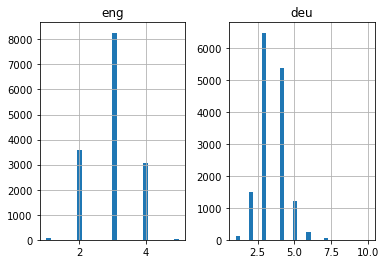

In [5]:
eng_l=[];deu_l=[]
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))
for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))
length_df=pd.DataFrame({'eng':eng_l,'deu':deu_l})
length_df.hist(bins=30)
plt.show()

In [6]:
def tokenization(lines):
    tokenizer=Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer
eng_tokenizer=tokenization(deu_eng[:,0])
eng_vocab_size=len(eng_tokenizer.word_index)+1
eng_length=8
print('English vocabulary size :%d' %eng_vocab_size)
deu_tokenizer=tokenization(deu_eng[:,1])
deu_vocab_size=len(deu_tokenizer.word_index)+1
deu_length=8
print('Deutch vocabulary size :%d' %deu_vocab_size)

English vocabulary size :2957
Deutch vocabulary size :4708


In [7]:
def encode_sequences(tokenizer,length,lines):
    seq=tokenizer.texts_to_sequences(lines)
    seq=pad_sequences(seq,maxlen=length,padding='post')
    return seq


In [8]:
#!pip install sklearn
#import sklearn as sk
from sklearn.model_selection import train_test_split
train,test=train_test_split(deu_eng,test_size=0.2,random_state=12)
trainX=encode_sequences(deu_tokenizer,deu_length,test[:,1])
trainY=encode_sequences(eng_tokenizer,eng_length,test[:,0])
testX=encode_sequences(deu_tokenizer,deu_length,train[:,1])
testY=encode_sequences(eng_tokenizer,eng_length,train[:,0])

In [9]:
def build_model(in_vocab,out_vocab,in_timesteps,out_timesteps,units):
    model=Sequential()
    model.add(Embedding(in_vocab,units,input_length=in_timesteps,mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units,return_sequences=True))
    model.add(Dense(out_vocab,activation='softmax'))
    return model
    

In [10]:
from tensorflow import keras
from keras import optimizers
model=build_model(deu_vocab_size,eng_vocab_size,deu_length,eng_length,512)
rms=keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms,loss='sparse_categorical_crossentropy')

In [11]:
filename='model.h1.24_srilallitha'
checkpoint=ModelCheckpoint(filename,monitor='val_loss',verbose=1,save_best_only=True,mode='min')

history=model.fit(trainX,trainY.reshape(trainY.shape[0],trainY.shape[1],1),
                  epochs=5,batch_size=512,validation_split=0.2,callbacks=[checkpoint],verbose=1)

Epoch 1/5
5/5 [==============================] - 32s 3s/step - loss: 6.0667 - val_loss: 3.0230

Epoch 00001: val_loss improved from inf to 3.02296, saving model to model.h1.24_srilallitha


INFO:tensorflow:Assets written to: model.h1.24_srilallitha\assets


INFO:tensorflow:Assets written to: model.h1.24_srilallitha\assets


Epoch 2/5
5/5 [==============================] - 9s 2s/step - loss: 2.8346 - val_loss: 2.7849

Epoch 00002: val_loss improved from 3.02296 to 2.78488, saving model to model.h1.24_srilallitha


INFO:tensorflow:Assets written to: model.h1.24_srilallitha\assets


INFO:tensorflow:Assets written to: model.h1.24_srilallitha\assets


Epoch 3/5
5/5 [==============================] - 9s 2s/step - loss: 2.6466 - val_loss: 2.6180

Epoch 00003: val_loss improved from 2.78488 to 2.61805, saving model to model.h1.24_srilallitha


INFO:tensorflow:Assets written to: model.h1.24_srilallitha\assets


INFO:tensorflow:Assets written to: model.h1.24_srilallitha\assets


Epoch 4/5
5/5 [==============================] - 10s 2s/step - loss: 2.5550 - val_loss: 2.6031

Epoch 00004: val_loss improved from 2.61805 to 2.60315, saving model to model.h1.24_srilallitha


INFO:tensorflow:Assets written to: model.h1.24_srilallitha\assets


INFO:tensorflow:Assets written to: model.h1.24_srilallitha\assets


Epoch 5/5
5/5 [==============================] - 9s 2s/step - loss: 2.3268 - val_loss: 2.4350

Epoch 00005: val_loss improved from 2.60315 to 2.43501, saving model to model.h1.24_srilallitha


INFO:tensorflow:Assets written to: model.h1.24_srilallitha\assets


INFO:tensorflow:Assets written to: model.h1.24_srilallitha\assets


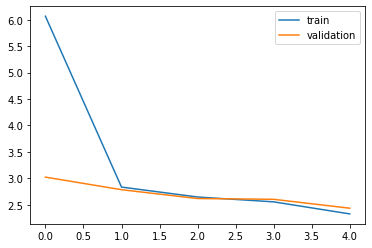

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()


In [13]:
model=load_model('model.h1.24_srilallitha')
preds=(model.predict(testX.reshape(testX.shape[0],testX.shape[1]))>0.5).astype('int32')

In [14]:
def get_word(n,tokenizer):
    for word, index in tokenizer.word_index.items():
        if (index==n).any():
            return word
    return None

In [15]:
import numpy as np
preds_text=[]
for i in preds:
    temp=[]
    for j in range(len(i)):
        t=get_word(i[j],eng_tokenizer)
        if j>0:
            if np.logical_or(t==get_word(i[j-1], eng_tokenizer),t==None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if (t==None):
                temp.append('')
            else:
                temp.append(t)
    preds_text.append(''.join(temp))
    

In [16]:
a={'actual':test[:,0],'predicted':preds_text}
pred_df=pd.DataFrame.from_dict(a,orient='index')
pred_df=pred_df.transpose()

In [17]:
pd.set_option('display.max_colwidth',200)

In [18]:
pred_df.head(10)

,actual,predicted
0,I feel weak.,tom
1,I love your cat.,tom
2,Tom is sweet.,tom
3,I'll be going.,tom
4,Is this it?,tom
5,Don't leave us.,tom
6,Form two lines.,tom
7,He's studying.,tom
8,You're good.,tom
9,Are you curious?,tom


In [19]:
pred_df.tail(10)

,actual,predicted
11990,None,tom
11991,None,tom
11992,None,tom
11993,None,tom
11994,None,tom
11995,None,tom
11996,None,tom
11997,None,tom
11998,None,tom
11999,None,tom
